Notebook to analize time series. There's not much planned other than playing around with AR or ARMA models.

Climate data
---

In [97]:
# load data
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
file_path = os.path.join('time_series_data', 'DailyDelhiClimateTrain.csv')
df = pd.read_csv(file_path)
df = df.set_index('date')
df = df.sort_index()
df.index = pd.to_datetime(df.index)

In [98]:
# filter out outliers
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3 - q1
outliers = (df > q3 + 3 * iqr) | (df < q1 - 3 * iqr)
for col in df:
    df.where(~outliers, df.median(), inplace=True, axis=1)

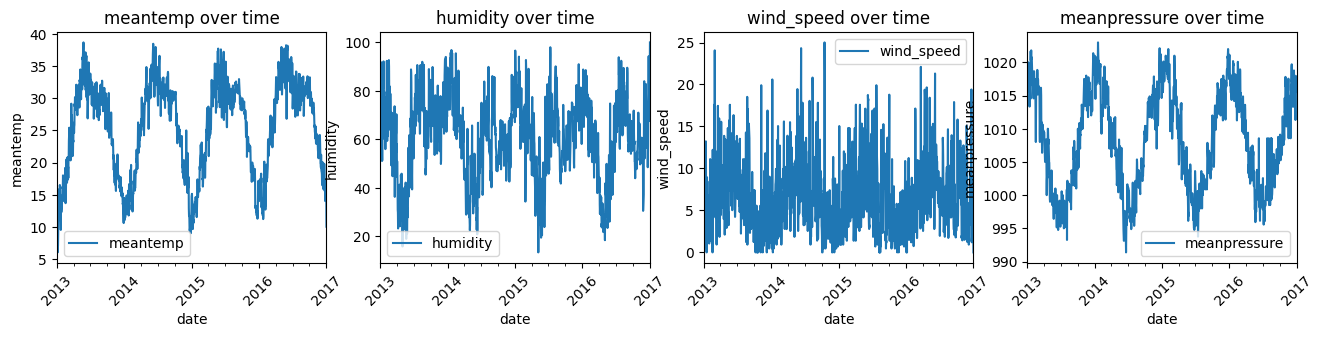

In [99]:
# plot data
fig, axs = plt.subplots(1, len(df.columns), figsize=(16, 3))
for col, ax in zip(df.columns, axs):
    df.plot(y=col, title=f"{col} over time", ylabel=f"{col}", rot=45, ax=ax)

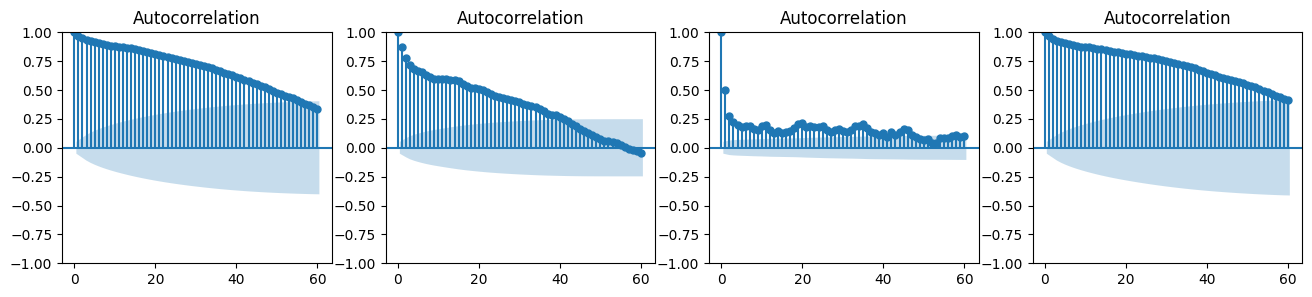

In [100]:
# plot auto-correlation matrix of each 
from statsmodels.graphics.tsaplots import plot_acf
fig, axs = plt.subplots(1, len(df.columns), figsize=(16, 3))
for col, ax in zip(df.columns, axs):
    plot_acf(df[col], lags=60, ax=ax)
plt.show()

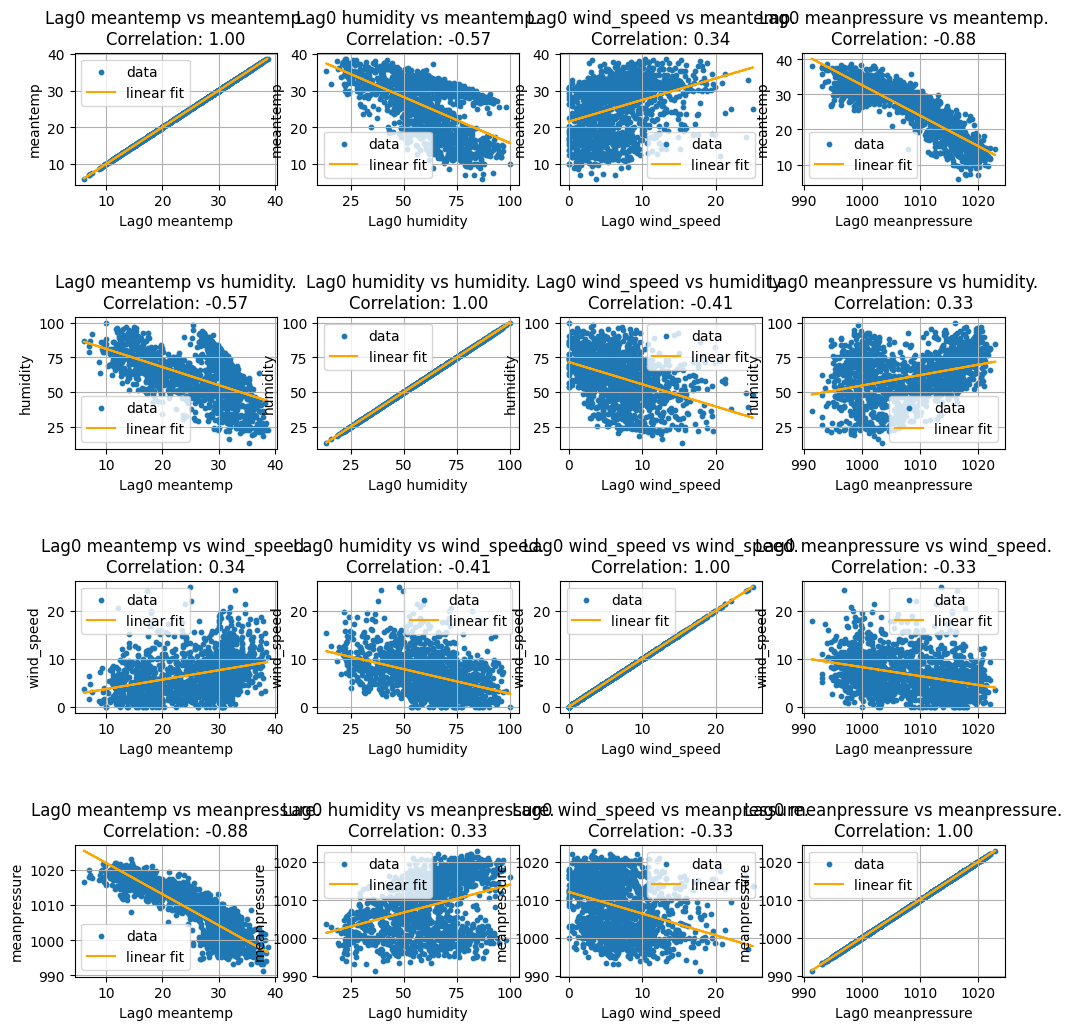

In [ ]:
# scatterplots lag1 vs lag0
lag = 1
fig, axm = plt.subplots(len(df.columns), len(df.columns), figsize=(12, 12))
for col1, axs in zip(df, axm):
    y_data = df[col1].values[lag:]
    for col2, ax in zip(df, axs):
        x_data = df[col2].values[:-lag]
        (cov_xx, cov_xy), (cov_xy, cov_yy) = np.cov(x_data, y_data)
        y_pred = (cov_xy / cov_xx) * (x_data - np.mean(x_data)) + np.mean(y_data)
        ax.scatter(x_data, y_data, label='data', s=10)
        ax.plot(x_data, y_pred, label='linear fit', color='orange')
        ax.set_xlabel(f'Lag{lag} {col2}')
        ax.set_ylabel(col1)
        ax.set_title(
            f"Lag{lag} {col2} vs {col1}.\nCorrelation: {cov_xy / np.sqrt(cov_xx * cov_yy):.2f}"
        )
        ax.legend(loc='best')
        ax.grid(True)
fig.subplots_adjust(hspace=1)
plt.show()

The model I choose is an AR(k) where k <= 50, with the difference that all three columns are used to predict the next value.

In particular, if $x_t,\dots , z_t$ represent the sequences, then the goal is to learn a matrix $\beta$ such that
$$\begin{bmatrix} x_t \\ \vdots \\ z_t \end{bmatrix} = \beta \cdot \begin{bmatrix} x_{t-1} & \cdots & x_{t-k} & 1 \\ \vdots & \ddots & \ddots & \vdots \\ z_{t-1} & \cdots & z_{t-k} & 1 \end{bmatrix} + \epsilon_t \,,$$
and this can be done by fitting a linear regression model to predict each $x_t, \cdots, z_t$.

---

In [127]:
# Fit the model
from scipy.stats import norm

def fit(df, k, alpha=0.05, lam=1e-8):
    """
    Fits an AR(k) model to each column in the dataframe, including all
    other columns into the model as well.
    Sets to 0 all coefficients that don't pass the hypothesis test.

    Args:
        df (pd.DataFrame): dataframe with the given data.
        k (int): order of the Auto Regressive model.
        alpha (float): level of the hypothesis test.
        lam (float, optional): regularization parameter.
    Returns:
        np.array: coefficients of the fitted model,
        float: prediction standard deviation of the model
    """
    z_val = norm.ppf(1 - alpha / 2)
    Id = np.eye(len(df.columns) * k + 1)

    X = np.empty((len(df) - k, len(df.columns) * k + 1))
    for j, col in enumerate(df):
        for i in range(1, k + 1):
            X[:, j * k + i - 1] = df[col].values[k - i : - i]
    X[:, -1] = 1
    XtX_inv = np.linalg.inv(X.T @ X + lam * Id)

    beta = np.empty((len(df.columns), len(df.columns) * k + 1))
    sigma = np.empty(len(df.columns))
    mask = np.empty((len(df.columns), len(df.columns) * k + 1), dtype=bool)
    for i, col in enumerate(df):
        y = df[col].values[k:]
        beta[i] = XtX_inv @ X.T @ y
        sigma[i] = np.sqrt(np.mean((y - X @ beta[i])**2))
        mask[i] = np.abs(beta[i]) >= sigma[i] * np.sqrt(np.diag(XtX_inv)) * z_val

    return beta, sigma, mask

In [94]:
# Predict future values function
def predict(df, beta):
    """
    Predicts each column's value at next time-step based on the AR model's coefficients.

    Args:
        df (pd.DataFrame): dataframe with the given data.
        beta (np.array): coefficients of the AR model.
    Returns:
        pd.DataFrame: dataframe with the next row.
    """
    k = (beta.shape[1] - 1) // beta.shape[0]
    x = np.empty(len(df.columns) * k + 1)
    for i, col in enumerate(df):
        x[i * k: i * k + k] = df[col].values[-k:]
    x[-1] = 1

    preds = beta @ x
    new_row = {df.index.name: df.index.max() + pd.Timedelta(days=1)}
    new_row.update({col: [val] for col, val in zip(df, preds)})

    return pd.DataFrame(new_row).set_index(df.index.name)

def predict_series(df, beta):
    """Returns the predictions of the model in the whole data interval."""
    k = (beta.shape[1] - 1) // beta.shape[0]
    pred_df = df.iloc[:k]
    for i in range(k, len(df)):
        past_df = df.iloc[:i]
        new_row = predict(past_df, beta)
        pred_df = pd.concat((pred_df, new_row))
    return pred_df

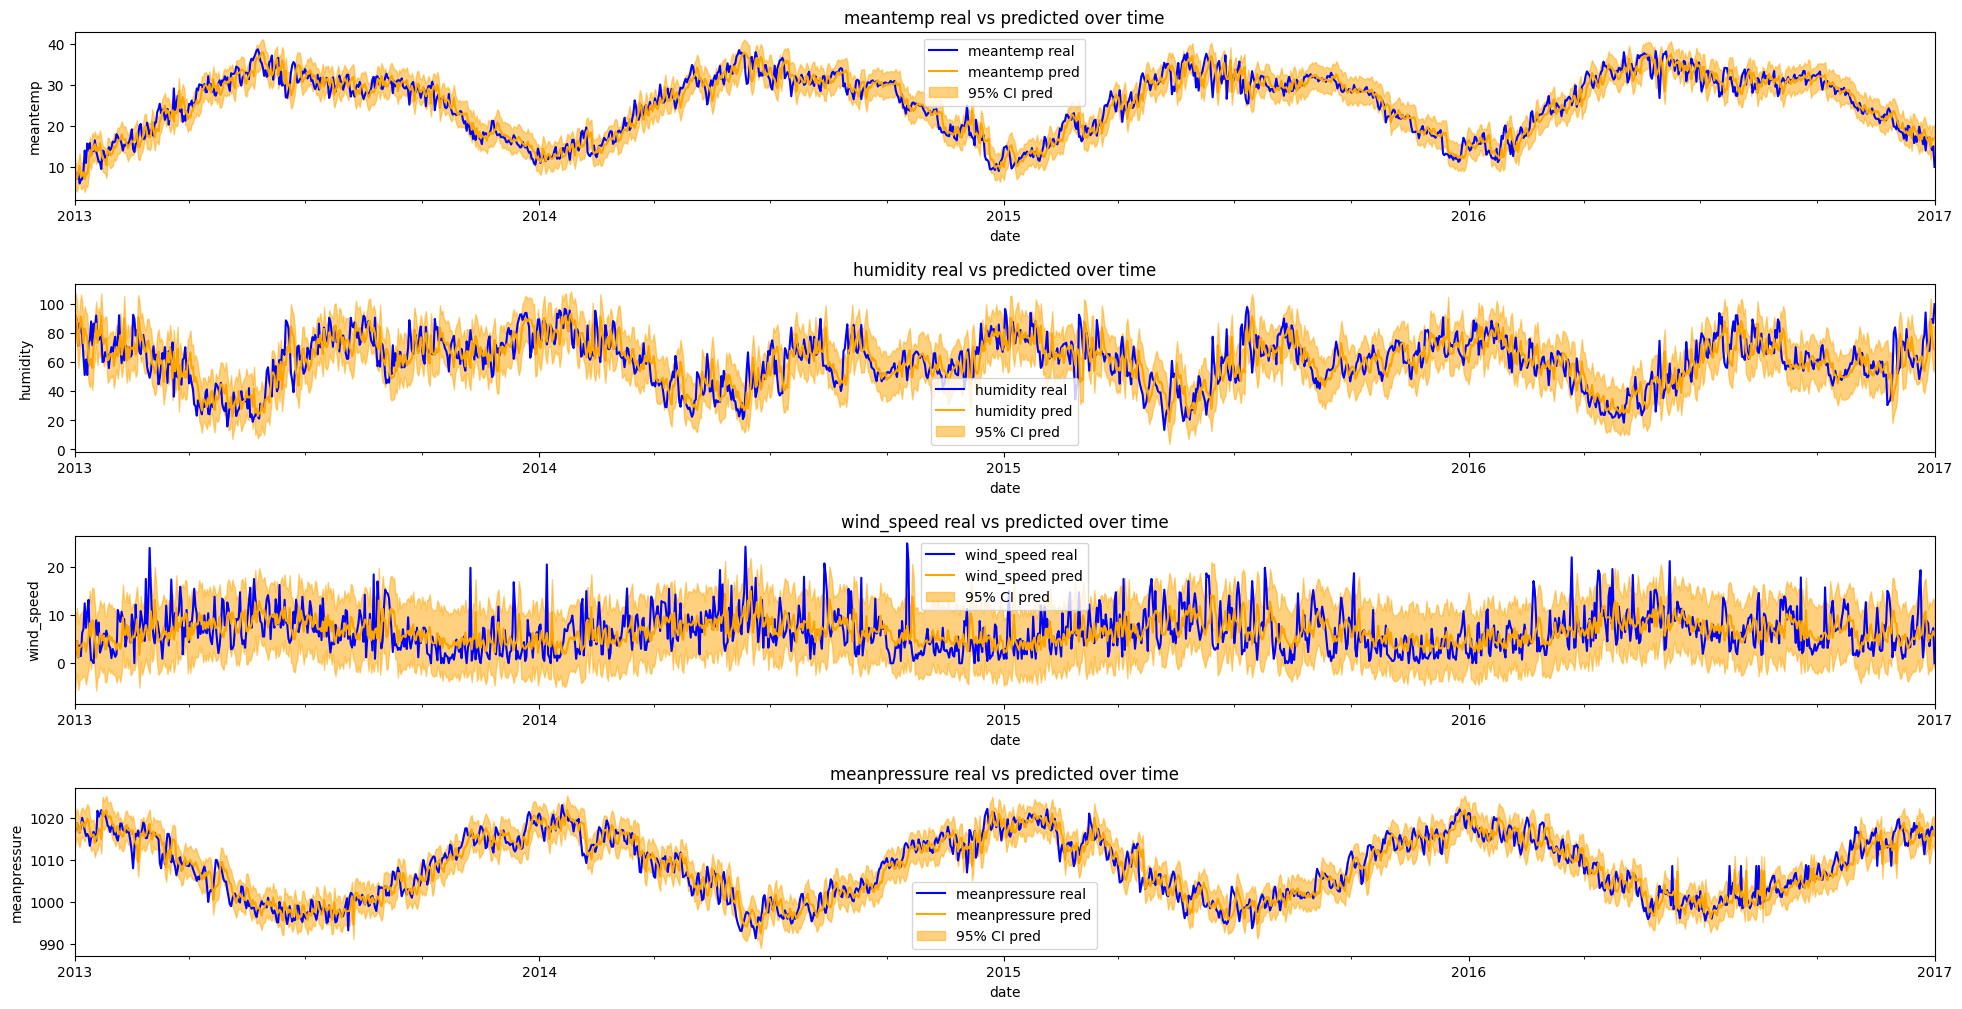

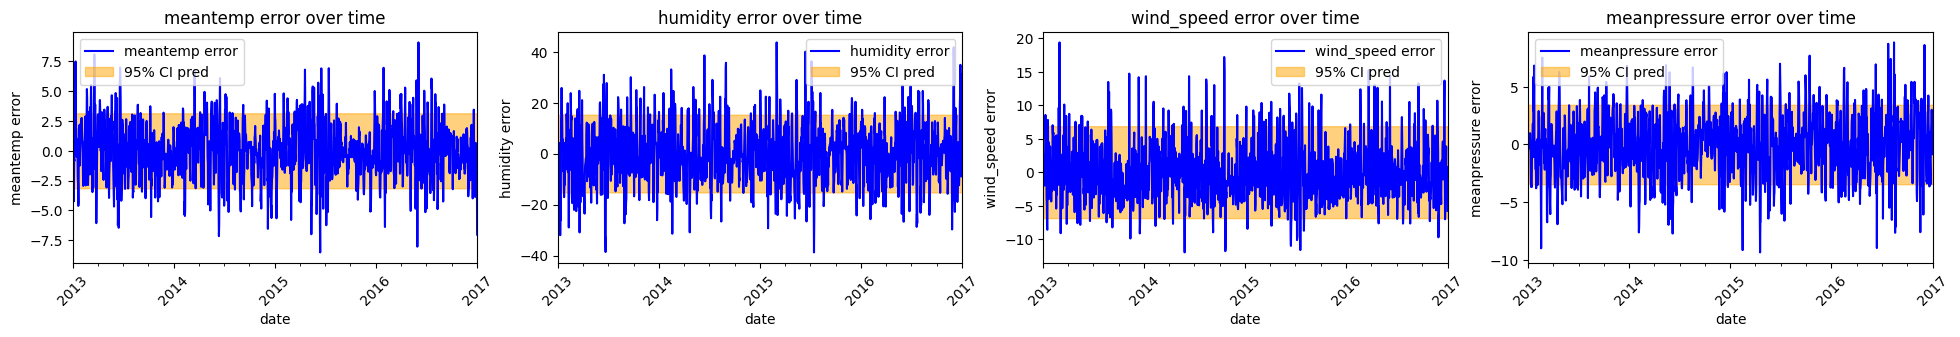

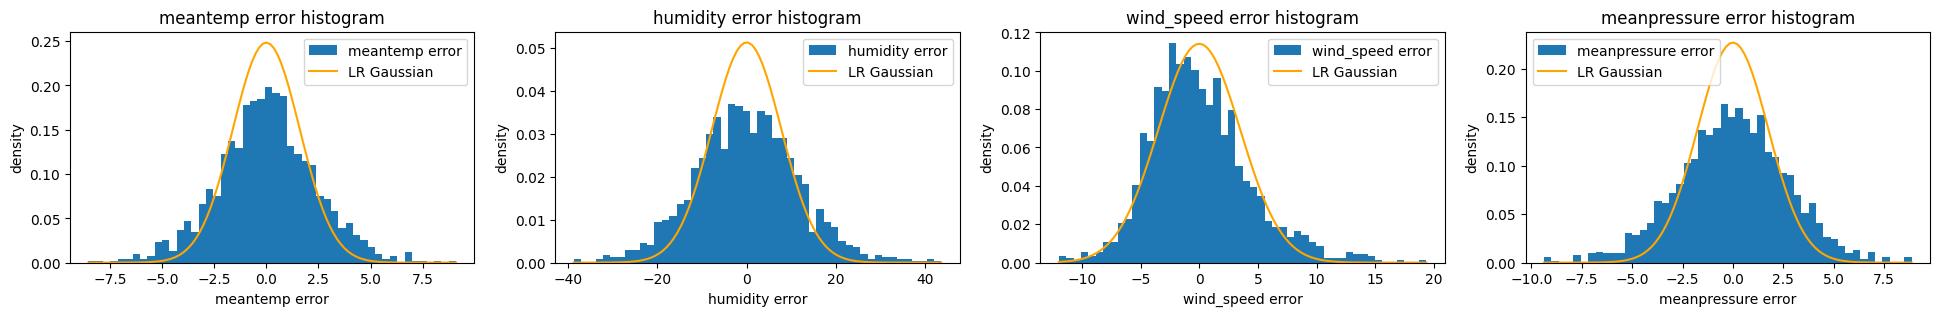

In [95]:
# Plot results
k = 4
alpha = 1/(k * 3 + 1)

beta, sigma, mask = fit(df, k=k, alpha=alpha)
pred_df = predict_series(df, beta)

fig, axs = plt.subplots(len(df.columns), 1, figsize=(24, 12))
for col, std, ax in zip(df, sigma, axs):
    df.plot(y=col, color='blue', label=f"{col} real", rot=45, ax=ax)
    pred_df.plot(y=col, color='orange', label=f"{col} pred", ax=ax)
    ax.fill_between(
        df.index, pred_df[col] - 1.96 * std, pred_df[col] + 1.96 * std,
        alpha=0.5, color='orange', label="95% CI pred",
    )
    ax.set_title(f"{col} real vs predicted over time")
    ax.set_xlabel(df.index.name)
    ax.set_ylabel(col)
    ax.legend()
fig.subplots_adjust(hspace=0.5)
plt.show()

fig, axs = plt.subplots(1, len(df.columns), figsize=(24, 3))
for col, std, ax in zip(df, sigma, axs):
    (df[col] - pred_df[col]).plot(x=df.index, color='blue', label=f'{col} error', rot=45, ax=ax)
    ax.fill_between(df.index, -1.96 * std, 1.96 * std, alpha=0.5, color='orange', label='95% CI pred')
    ax.set_title(f"{col} error over time")
    ax.set_xlabel(df.index.name)
    ax.set_ylabel(f"{col} error")
    ax.legend()
plt.show()

fig, axs = plt.subplots(1, len(df.columns), figsize=(24, 3))
for col, std, ax in zip(df, sigma, axs):
    errors = df[col] - pred_df[col]
    x = np.linspace(errors.min(), errors.max(), 100)
    normal_pdf = 1 / (std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x / std)**2)
    errors.plot(kind='hist', bins=50, label=f'{col} error', density=True, ax=ax)
    ax.plot(x, normal_pdf, color='orange', label='LR Gaussian')
    ax.set_title(f"{col} error histogram")
    ax.set_xlabel(f"{col} error")
    ax.set_ylabel('density')
    ax.legend()
plt.show()

In [87]:
# Find best value of k
ks = range(1, 10)
l2_vals = {col: [] for col in df}

for k in ks:
    alpha = 1 / (len(df.columns) * k + 1)
    beta, sigma, mask = fit(df, k, alpha)
    pred_df = predict_series(df, beta)
    for col in df:
        error = df[col] - pred_df[col]
        l2_vals[col].append(np.mean(error**2))

print(l2_vals)

{'meantemp': [2.57720006991983, 2.603143187286824, 2.5411010706034776, 2.5600780697722185, 2.5111796469790035, 2.7000004405824662, 2.7033188891457507, 2.8424093622245454, 2.748868953815011], 'humidity': [62.49268501258552, 64.23958533521079, 60.217814384970694, 61.04984428285599, 62.13551389527536, 63.978572629363285, 65.07139819659523, 65.91825459662908, 65.86081311625658], 'wind_speed': [15.108514195947189, 15.207151565245507, 15.797505307318668, 17.037507672269125, 16.946974170395535, 18.058040954991366, 18.864865105557254, 18.83197038409673, 17.798228697101255], 'meanpressure': [2.594952454856451, 3.274275263475913, 2.597305765846333, 2.6491940280053408, 2.8211073230313435, 2.793929741908684, 2.872976074696958, 2.9185993349685333, 2.8204848232875435]}


Rubiks cube
---

In [125]:
import numpy as np
with open("C:\\Users\\sofia\\Downloads\\cstimer_20250801_230915.txt", "r") as f:
    data = f.read()
data = data.split("\n")
data = [d.split() for d in data]
ids = np.array([d[0][:-1] for d in data]).astype(int)
times = np.array([d[1].split("[")[0] for d in data]).astype(float)

p-value of slope is 0.0026864841456658893. The correlation is likely non-zero


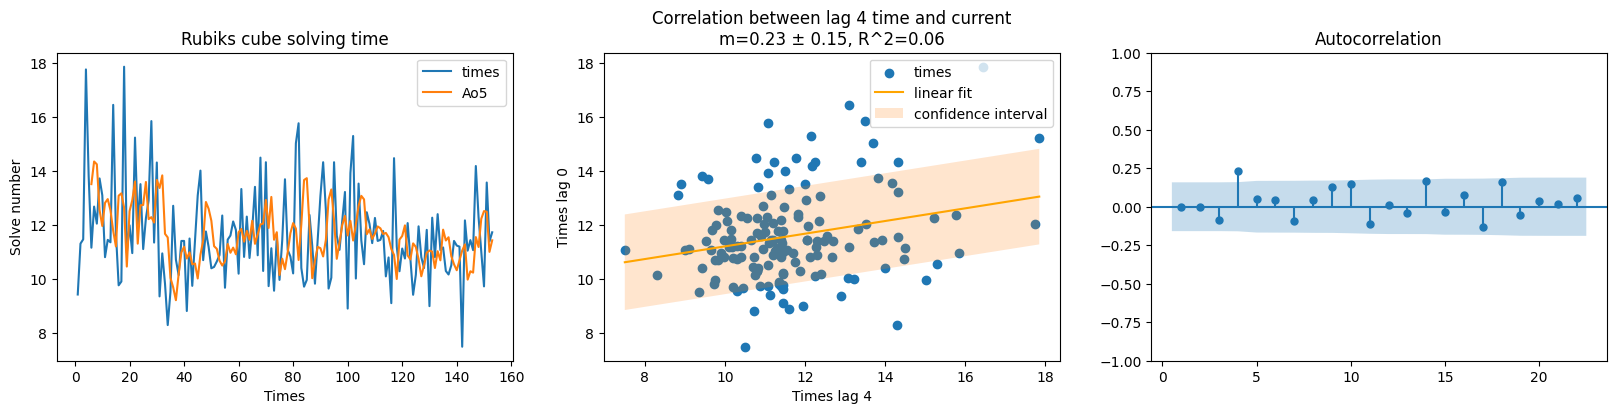

In [133]:
# Correlations
import matplotlib.pyplot as plt
from scipy.stats import linregress
from statsmodels.graphics.tsaplots import plot_acf

avg_size = 5
kernel = np.ones(2 * avg_size + 1) / (avg_size - 2)
kernel[0] = 0
kernel[avg_size - 1:] = 0
kernel = np.flip(kernel)

fig, axs = plt.subplots(1, 3, figsize=(20, 4))
axs[0].plot(ids, times, label="times")
axs[0].plot(ids[avg_size:], np.convolve(times, kernel, mode='same')[avg_size:], label=f"Ao{avg_size}")
axs[0].set_xlabel("Times")
axs[0].set_ylabel("Solve number")
axs[0].set_title("Rubiks cube solving time")
axs[0].legend()

lags = 4
result = linregress(times[:-lags], times[lags:])
m, b, r, p, m_std = result
std = result.intercept_stderr
T = np.linspace(times.min(), times.max(), len(times))
predicted = m * T + b

axs[1].scatter(times[:-lags], times[lags:], label="times")
axs[1].plot(T, predicted, label="linear fit", color='orange')
axs[1].fill_between(T, predicted - 1.96 * std, predicted + 1.96 * std, label="confidence interval", alpha=0.2)
axs[1].set_xlabel(f"Times lag {lags}")
axs[1].set_ylabel("Times lag 0")
axs[1].set_title(f"Correlation between lag {lags} time and current\nm={m:.2g} {chr(0x00B1)} {1.96 * m_std:.2g}, R^2={r**2:.2g}")
axs[1].legend(loc='best')

print(f"p-value of slope is {p}. ", end='')
if p < 0.05:
    print("The correlation is likely non-zero")
else:
    print("The correlation is likely zero")

plot_acf(times, zero=False, ax=axs[2])

plt.show()